In [0]:
files = dbutils.fs.ls("/mnt/my-mount")
print(files)

[FileInfo(path='dbfs:/mnt/my-mount/FDS_Dataset.JPG', name='FDS_Dataset.JPG', size=231190, modificationTime=1744691025000), FileInfo(path='dbfs:/mnt/my-mount/fds_pdf_encoded_data.csv', name='fds_pdf_encoded_data.csv', size=118232673, modificationTime=1746174281000), FileInfo(path='dbfs:/mnt/my-mount/fds_pdf_encoded_data2.csv', name='fds_pdf_encoded_data2.csv', size=118232676, modificationTime=1746174485000), FileInfo(path='dbfs:/mnt/my-mount/fraud_detection_dataset_with_full_columns.csv', name='fraud_detection_dataset_with_full_columns.csv', size=39891173, modificationTime=1745382516000), FileInfo(path='dbfs:/mnt/my-mount/synthetic_transaction_data.csv', name='synthetic_transaction_data.csv', size=116321723, modificationTime=1746086547000)]


In [0]:
import pandas as pd

fds_pdf = pd.read_csv("/dbfs/mnt/my-mount/synthetic_transaction_data.csv")
print(fds_pdf.head()) 

      transaction_time  TransactionDT  ... app_version  rooting
0  2025-01-14 09:56:23          86400  ...       3.1.0    False
1  2025-04-20 22:42:41          86401  ...       3.4.3    False
2  2025-04-09 19:27:13          86469  ...       1.2.1     True
3  2025-01-30 01:26:54          86499  ...       3.8.1     True
4  2025-01-24 22:58:30          86506  ...       3.6.0     True

[5 rows x 23 columns]


In [0]:
import numpy as np

fds_pdf['DeviceInfo'] = fds_pdf['DeviceInfo'].replace('Unknown',np.nan)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print(fds_pdf.head())

      transaction_time  TransactionDT recipient  TransactionAmt  hour  \
0  2025-01-14 09:56:23          86400        춘자         68500.0     9   
1  2025-04-20 22:42:41          86401        수빈         29000.0    22   
2  2025-04-09 19:27:13          86469        서준         59000.0    19   
3  2025-01-30 01:26:54          86499        병철         50000.0     1   
4  2025-01-24 22:58:30          86506        민수         50000.0    22   

   voice_match                     DeviceInfo region receiver_bank  \
0         True                            NaN     대구          토스뱅크   
1        False                            NaN     대구         카카오뱅크   
2         True                            NaN     부산          신한은행   
3         True                            NaN     부산         카카오뱅크   
4         True  SAMSUNG SM-G892A Build/NRD90M     서울          우리은행   

   receiver_account  is_new_account_for_user  avg_amount_to_bank  \
0     1000000266274                    False              481616   
1   

Data Scaling

In [0]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Boolean columns → int 변환
bool_cols=[
    'voice_match',
    'is_new_account_for_user',
    'is_new_device',
    'vpn',
    'rooting'
]

fds_pdf[bool_cols] = fds_pdf[bool_cols].astype(int)

categorical_cols = ['payment_method', 'intent', 'authentication']
fds_pdf_encoded= pd.get_dummies(fds_pdf, columns=categorical_cols, drop_first=False)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print(fds_pdf_encoded.head())
exclude_cols =[
    'transaction_time', 'TransactionDT', 'recipient', 'region', 'DeviceInfo',             
    'receiver_bank', 'receiver_account', 'ip_address', 'app_version'
]

features = [col for col in fds_pdf_encoded.columns if col not in exclude_cols]
print(features)
print('*'*100)

# 정규화 (스케일링)
scaler = StandardScaler()
X = scaler.fit_transform(fds_pdf_encoded[features])

print(X)


      transaction_time  TransactionDT recipient  TransactionAmt  hour  \
0  2025-01-14 09:56:23          86400        춘자         68500.0     9   
1  2025-04-20 22:42:41          86401        수빈         29000.0    22   
2  2025-04-09 19:27:13          86469        서준         59000.0    19   
3  2025-01-30 01:26:54          86499        병철         50000.0     1   
4  2025-01-24 22:58:30          86506        민수         50000.0    22   

   voice_match                     DeviceInfo region receiver_bank  \
0            1                            NaN     대구          토스뱅크   
1            0                            NaN     대구         카카오뱅크   
2            1                            NaN     부산          신한은행   
3            1                            NaN     부산         카카오뱅크   
4            1  SAMSUNG SM-G892A Build/NRD90M     서울          우리은행   

   receiver_account  is_new_account_for_user  avg_amount_to_bank  \
0     1000000266274                        0              481616   
1   

Unsupervised Learning 적용① - Isolation Forest

In [0]:
from sklearn.ensemble import IsolationForest
import numpy as np

iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
print(iso_forest)
iso_forest.fit(X)

# 이상치 예측 (-1: 이상치, 1: 정상치)
preds = iso_forest.predict(X)
print(preds)

# 이상치 여부를 0/1로 변환 (1: 이상거래)
fds_pdf_encoded['anomaly_iforest'] = np.where(preds==-1, 1, 0)

#결과 확인
print('*'*100)
print('전체 이상 거래 개수')
print('*'*100)
print(fds_pdf_encoded['anomaly_iforest'].value_counts())

IsolationForest(contamination=0.05, random_state=42)
[ 1  1  1 ...  1  1 -1]
****************************************************************************************************
전체 이상 거래 개수
****************************************************************************************************
0    561013
1     29527
Name: anomaly_iforest, dtype: int64


In [0]:
print(fds_pdf_encoded.head())

      transaction_time  TransactionDT recipient  TransactionAmt  hour  \
0  2025-01-14 09:56:23          86400        춘자         68500.0     9   
1  2025-04-20 22:42:41          86401        수빈         29000.0    22   
2  2025-04-09 19:27:13          86469        서준         59000.0    19   
3  2025-01-30 01:26:54          86499        병철         50000.0     1   
4  2025-01-24 22:58:30          86506        민수         50000.0    22   

   voice_match                     DeviceInfo region receiver_bank  \
0            1                            NaN     대구          토스뱅크   
1            0                            NaN     대구         카카오뱅크   
2            1                            NaN     부산          신한은행   
3            1                            NaN     부산         카카오뱅크   
4            1  SAMSUNG SM-G892A Build/NRD90M     서울          우리은행   

   receiver_account  is_new_account_for_user  avg_amount_to_bank  \
0     1000000266274                        0              481616   
1   

In [0]:
anomalies = fds_pdf_encoded[fds_pdf_encoded['anomaly_iforest'] == 1]
display(anomalies.head())


/databricks/spark/python/pyspark/sql/pandas/conversion.py:477: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field payment_method_P01. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: [UNSUPPORTED_DATA_TYPE_FOR_ARROW_CONVERSION] uint8 is not supported in conversion to Arrow.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


transaction_time,TransactionDT,recipient,TransactionAmt,hour,voice_match,DeviceInfo,region,receiver_bank,receiver_account,is_new_account_for_user,avg_amount_to_bank,amount_ratio_to_bank_avg,is_nighttime,recent_transaction_gap,is_new_device,ip_address,vpn,app_version,rooting,payment_method_P01,payment_method_P02,payment_method_P03,payment_method_P04,payment_method_P05,payment_method_P06,intent_T01,intent_T02,intent_T03,intent_T04,intent_T05,authentication_A01,authentication_A02,authentication_A03,authentication_A04,authentication_A05,authentication_A06,anomaly_iforest
2025-03-08 05:20:47,87532,명자,380210.0,5,1,NaN,광주,하나은행,1000000398441,0,89452,4.250435988015919,1,18.862544871110025,1,15.188.141.62,0,1.5.4,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1
2025-04-23 19:47:12,87581,도윤,2454000.0,19,1,NaN,광주,하나은행,1000000538790,1,90721,27.04996638044113,0,115.41934277364273,1,116.44.59.33,1,3.1.1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1
2025-01-06 12:18:44,88107,정웅,527000.0,12,0,NaN,대구,신한은행,1000000555850,0,76753,6.866181126470627,0,115.64596318252252,1,185.253.50.136,0,1.6.4,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1
2025-01-06 04:40:54,88162,유진,75000.0,4,1,iOS Device,속초,토스뱅크,1000000582828,0,95523,0.785151220124996,1,355.0833400328701,1,203.251.88.208,0,3.8.0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1
2025-01-05 20:19:01,88380,채원,1153950.0,20,0,NaN,부산,카카오뱅크,1000000564016,0,446310,2.5855347180211066,0,124.80687353452042,0,192.167.186.254,0,3.5.4,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1


In [0]:
normal = fds_pdf_encoded[fds_pdf_encoded['anomaly_iforest'] == 0]

features_to_compare = [
    'TransactionAmt', 'hour', 'is_nighttime', 'vpn',
    'is_new_device', 'amount_ratio_to_bank_avg'
]

anomaly_mean = anomalies[features_to_compare].mean().round(2)
normal_mean = normal[features_to_compare].mean().round(2)

comparison_df = pd.DataFrame({
    'Anomaly Mean': anomaly_mean,
    'Normal Mean': normal_mean
})
print(comparison_df)

                          Anomaly Mean  Normal Mean
TransactionAmt               711861.64    104667.47
hour                              8.36        11.65
is_nighttime                      0.53         0.24
vpn                               0.51         0.50
is_new_device                     0.49         0.50
amount_ratio_to_bank_avg          4.30         0.50


Unsupervised Learning 적용② - Autoencoder

In [0]:
pip install torch

  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/0e/6b/87fcddd34df9f53880fa1f0c23af7b6b96c935856473faf3914323588c40/torch-2.7.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata
  Obtaining dependency information for sympy>=1.13.3 from https://files.pythonhosted.org/packages/a2/09/77d55d46fd61b4a135c444fc97158ef34a095e5681d0a6c10b75bf356191/sympy-1.14.0-py3-none-any.whl.metadata
  Obtaining dependency information for networkx from https://files.pythonhosted.org/packages/b9/54/dd730b32ea14ea797530a4479b2ed46a6fb250f682a9cfb997e968bf0261/networkx-3.4.2-py3-none-any.whl.metadata
  Obtaining dependency information for jinja2 from https://files.pythonhosted.org/packages/62/a1/3d680cbfd5f4b8f15abc1d571870c5fc3e594bb582bc3b64ea099db13e56/jinja2-3.1.6-py3-none-any.whl.metadata
  Obtaining dependency information for fsspec from https://files.pythonhosted.org/packages/44/4b/e0cfc1a6f17e990f3e64b7d941ddc4acdc7b19d6edd51abf495f32b1a9e4/fsspec-2025.3.2-py3-none

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim

class AutoEncoder(nn.Module):
    def __init__(self, input_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [0]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# X: StandardScaler로 정규화된 데이터라고 가정
X_train, X_val = train_test_split(X, test_size=0.2, random_state=42)

# Tensor로 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=64, shuffle=True)

# 모델 초기화
input_dim = X.shape[1]
model = AutoEncoder(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 학습
n_epochs = 30
model.train()
for epoch in range(n_epochs):
    for batch in train_loader:
        x_batch = batch[0]
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, x_batch)
        loss.backward()
        optimizer.step()

In [0]:
# 재구성 오차 
model.eval()
X_tensor = torch.tensor(X, dtype=torch.float32)
with torch.no_grad():
    recon = model(X_tensor)
    mse = torch.mean((X_tensor - recon) ** 2, dim=1).numpy()


In [0]:
# 오차가 큰 경우, pseudo_labels =1 (이상치)
import numpy as np

threshold = np.percentile(mse, 95)  # 상위 5% 이상치는 이상 거래
pseudo_labels = (mse > threshold).astype(int)

# 저장
fds_pdf_encoded['anomaly_autoencoder'] = pseudo_labels

# 확인
print(fds_pdf_encoded['anomaly_autoencoder'].value_counts())


0    561013
1     29527
Name: anomaly_autoencoder, dtype: int64


In [0]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print(fds_pdf_encoded.head())

      transaction_time  TransactionDT recipient  TransactionAmt  hour  \
0  2025-01-14 09:56:23          86400        춘자         68500.0     9   
1  2025-04-20 22:42:41          86401        수빈         29000.0    22   
2  2025-04-09 19:27:13          86469        서준         59000.0    19   
3  2025-01-30 01:26:54          86499        병철         50000.0     1   
4  2025-01-24 22:58:30          86506        민수         50000.0    22   

   voice_match                     DeviceInfo region receiver_bank  \
0            1                            NaN     대구          토스뱅크   
1            0                            NaN     대구         카카오뱅크   
2            1                            NaN     부산          신한은행   
3            1                            NaN     부산         카카오뱅크   
4            1  SAMSUNG SM-G892A Build/NRD90M     서울          우리은행   

   receiver_account  is_new_account_for_user  avg_amount_to_bank  \
0     1000000266274                        0              481616   
1   

Unsupervised Learning 적용③ - VAE

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#VAE 모델 정의
class VAE(nn.Module):
    def __init__(self, input_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc_mu = nn.Linear(16, 8)
        self.fc_logvar = nn.Linear(16, 8)

        self.fc3 = nn.Linear(8, 16)
        self.fc4 = nn.Linear(16, 32)
        self.fc_out = nn.Linear(32, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        mu = self.fc_mu(h2)
        logvar = self.fc_logvar(h2)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h4 = F.relu(self.fc4(h3))
        return self.fc_out(h4)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar


In [0]:
from torch.utils.data import DataLoader, TensorDataset

#VAE 모델 학습
X_tensor = torch.tensor(X, dtype=torch.float32)
train_loader = DataLoader(TensorDataset(X_tensor), batch_size=64, shuffle=True)

vae = VAE(input_dim=X.shape[1])
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

def vae_loss(x, x_recon, mu, logvar):
    recon_loss = F.mse_loss(x_recon, x, reduction='mean')
    kl_div = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

vae.train()
n_epochs = 30
for epoch in range(n_epochs):
    for batch in train_loader:
        x_batch = batch[0]
        optimizer.zero_grad()
        x_recon, mu, logvar = vae(x_batch)
        loss = vae_loss(x_batch, x_recon, mu, logvar)
        loss.backward()
        optimizer.step()


In [0]:
# 복원 오차 기반 이상치 판별
vae.eval()
with torch.no_grad():
    x_recon, _, _ = vae(X_tensor)
    recon_error = torch.mean((X_tensor - x_recon) ** 2, dim=1).numpy()

# 오차 상위 5%를 이상치로 간주
import numpy as np
threshold = np.percentile(recon_error, 95)
pseudo_labels_vae = (recon_error > threshold).astype(int)


In [0]:
# pseudo label 출력
fds_pdf_encoded['anomaly_vae'] = pseudo_labels_vae
print(fds_pdf_encoded['anomaly_vae'].value_counts())


0    561013
1     29527
Name: anomaly_vae, dtype: int64


In [0]:
# fds_pdf_encoded 데이터 저장
fds_pdf_encoded.to_csv("/dbfs/mnt/my-mount/fds_pdf_encoded_data2.csv", index=False, encoding='utf-8-sig')

In [0]:
import pandas as pd

unsupervised_pdf = pd.read_csv("/dbfs/mnt/my-mount/fds_pdf_encoded_data2.csv")
print(unsupervised_pdf.head()) 

      transaction_time  TransactionDT recipient  TransactionAmt  hour  \
0  2025-01-14 09:56:23          86400        춘자         68500.0     9   
1  2025-04-20 22:42:41          86401        수빈         29000.0    22   
2  2025-04-09 19:27:13          86469        서준         59000.0    19   
3  2025-01-30 01:26:54          86499        병철         50000.0     1   
4  2025-01-24 22:58:30          86506        민수         50000.0    22   

   voice_match                     DeviceInfo region receiver_bank  \
0            1                            NaN     대구          토스뱅크   
1            0                            NaN     대구         카카오뱅크   
2            1                            NaN     부산          신한은행   
3            1                            NaN     부산         카카오뱅크   
4            1  SAMSUNG SM-G892A Build/NRD90M     서울          우리은행   

   receiver_account  is_new_account_for_user  avg_amount_to_bank  \
0     1000000266274                        0              481616   
1   

Risk Score 계산

In [0]:
# 각 모델에서 나온 이상도 점수 추출
scores_iforest = -iso_forest.decision_function(X)  # 낮을수록 이상치 → 부호 반전
scores_ae = mse  # 이미 계산된 재구성 오차
scores_vae = recon_error  # 이미 계산된 재구성 오차

print(scores_iforest)
print(scores_ae)
print(scores_vae)

[-0.03850879 -0.04263287 -0.04176648 ... -0.03575005 -0.04267507
  0.00702766]
[0.19587532 0.21342492 0.10952801 ... 0.11955129 0.09259665 0.24708028]
[0.9142493  0.98625576 0.86831886 ... 0.9484471  0.87746304 1.0753839 ]


In [0]:
# 점수 정규화(0~1) → 서로 다른 모델 간 비교를 위해 각 스코어를 동일한 스케일로 정규화해야 함.
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
scores_iforest_scaled = min_max_scaler.fit_transform(scores_iforest.reshape(-1, 1)).flatten()
scores_ae_scaled = min_max_scaler.fit_transform(scores_ae.reshape(-1, 1)).flatten()
scores_vae_scaled = min_max_scaler.fit_transform(scores_vae.reshape(-1, 1)).flatten()
print(scores_iforest_scaled)
print(scores_ae_scaled)
print(scores_vae_scaled)

[0.24631908 0.22312551 0.22799802 ... 0.26183406 0.2228882  0.50241314]
[1.2720756e-04 1.4159620e-04 5.6412846e-05 ... 6.4630774e-05 4.2531112e-05
 1.6918966e-04]
[2.4302150e-05 3.8692204e-05 1.5123223e-05 ... 3.1136369e-05 1.6950638e-05
 5.6503923e-05]


In [0]:
# 통합 Risk Score 계산
# 방법1: 단순 평균
unsupervised_pdf['avg_risk_score']=(
    scores_iforest_scaled + scores_ae_scaled + scores_vae_scaled
)/3
print(unsupervised_pdf.head())

      transaction_time  TransactionDT recipient  TransactionAmt  hour  \
0  2025-01-14 09:56:23          86400        춘자         68500.0     9   
1  2025-04-20 22:42:41          86401        수빈         29000.0    22   
2  2025-04-09 19:27:13          86469        서준         59000.0    19   
3  2025-01-30 01:26:54          86499        병철         50000.0     1   
4  2025-01-24 22:58:30          86506        민수         50000.0    22   

   voice_match                     DeviceInfo region receiver_bank  \
0            1                            NaN     대구          토스뱅크   
1            0                            NaN     대구         카카오뱅크   
2            1                            NaN     부산          신한은행   
3            1                            NaN     부산         카카오뱅크   
4            1  SAMSUNG SM-G892A Build/NRD90M     서울          우리은행   

   receiver_account  is_new_account_for_user  avg_amount_to_bank  \
0     1000000266274                        0              481616   
1   

In [0]:
# 방법 2: 가중 평균 (모델별 신뢰도 반영)
unsupervised_pdf['weighted_risk_score'] = (
    0.3 * scores_iforest_scaled +
    0.4 * scores_ae_scaled +
    0.3 * scores_vae_scaled
)

print(unsupervised_pdf.head())

      transaction_time  TransactionDT recipient  TransactionAmt  hour  \
0  2025-01-14 09:56:23          86400        춘자         68500.0     9   
1  2025-04-20 22:42:41          86401        수빈         29000.0    22   
2  2025-04-09 19:27:13          86469        서준         59000.0    19   
3  2025-01-30 01:26:54          86499        병철         50000.0     1   
4  2025-01-24 22:58:30          86506        민수         50000.0    22   

   voice_match                     DeviceInfo region receiver_bank  \
0            1                            NaN     대구          토스뱅크   
1            0                            NaN     대구         카카오뱅크   
2            1                            NaN     부산          신한은행   
3            1                            NaN     부산         카카오뱅크   
4            1  SAMSUNG SM-G892A Build/NRD90M     서울          우리은행   

   receiver_account  is_new_account_for_user  avg_amount_to_bank  \
0     1000000266274                        0              481616   
1   

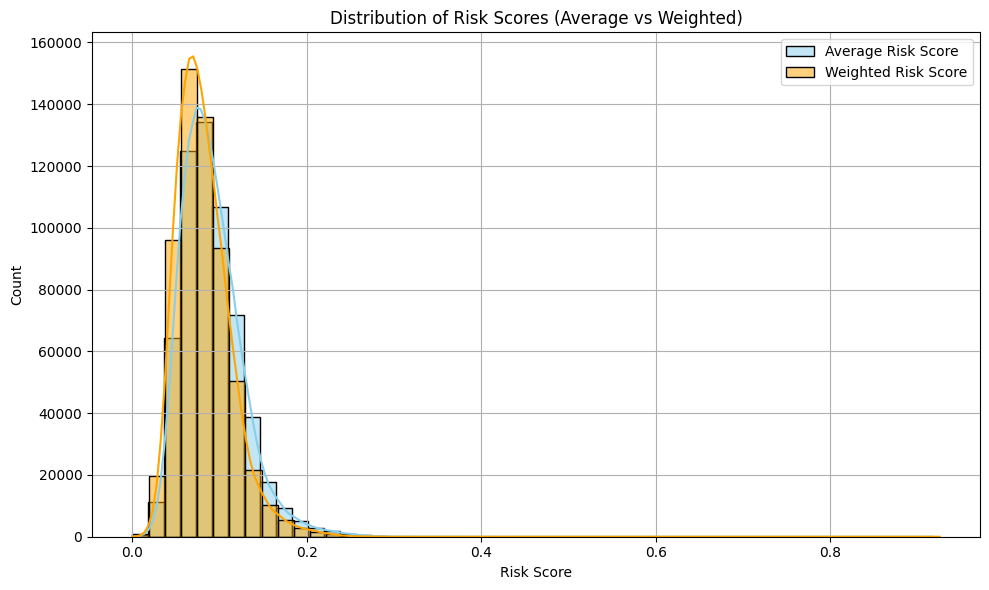

In [0]:
# Risk Score 분포 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# 평균 risk score 분포
sns.histplot(unsupervised_pdf['avg_risk_score'], bins=50, kde=True, color='skyblue', label='Average Risk Score')

# 가중평균 risk score 분포
sns.histplot(unsupervised_pdf['weighted_risk_score'], bins=50, kde=True, color='orange', label='Weighted Risk Score')

plt.title('Distribution of Risk Scores (Average vs Weighted)')
plt.xlabel('Risk Score')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [0]:
# pseudo label 생성
threshold_avg = unsupervised_pdf['avg_risk_score'].quantile(0.95)
unsupervised_pdf['pseudo_label_avg'] = (unsupervised_pdf['avg_risk_score'] >= threshold_avg).astype(int)

threshold_weighted = unsupervised_pdf['weighted_risk_score'].quantile(0.95)
unsupervised_pdf['pseudo_label_weighted'] =  (unsupervised_pdf['weighted_risk_score'] >= threshold_weighted).astype(int)

print("🔍 평균 기반 이상 거래 수:\n", unsupervised_pdf['pseudo_label_avg'].value_counts())
print("\n🔍 가중 평균 기반 이상 거래 수:\n", unsupervised_pdf['pseudo_label_weighted'].value_counts())

🔍 평균 기반 이상 거래 수:
 0    561013
1     29527
Name: pseudo_label_avg, dtype: int64

🔍 가중 평균 기반 이상 거래 수:
 0    561013
1     29527
Name: pseudo_label_weighted, dtype: int64


In [0]:
unsupervised_pdf.to_csv("/dbfs/mnt/my-mount/unsupervised_pdf.csv", index=False, encoding='utf-8-sig')